In [1]:
#%ls /var/env-dataset


In [2]:
#import torch.cuda 
#torch.cuda.is_available()

### Librerias

In [1]:
import xml.etree.ElementTree as ET
import glob
import os
import sys
import shutil
import numpy as np
from numpy import sin, cos, sqrt, pi
import math
import matplotlib.pyplot as plt 
from pathlib import Path
from ultralytics import SAM

### Funciones

In [2]:
def my_auto_annotate(xmls_path, sam_model='sam_b.pt', device='', images_dir=None, output_dir=None):
    """
    Modificacion de la funcion de ulstrlytics que ->
    Automatically annotates images using a YOLO object detection model and a SAM segmentation model.
    Args:
        data (str): Path to a folder containing images to be annotated.
        det_model (str, optional): Pre-trained YOLO detection model. Defaults to 'yolov8x.pt'. #Quitado
        sam_model (str, optional): Pre-trained SAM segmentation model. Defaults to 'sam_b.pt'.
        device (str, optional): Device to run the models on. Defaults to an empty string (CPU or GPU, if available).
        output_dir (str | None | optional): Directory to save the annotated results.
            Defaults to a 'labels' folder in the same directory as 'data'.
    """
    sam_model = SAM(sam_model)
    if not images_dir:
        print("No se ha proporcionado la dirección de las imágenes")
        return

    if not output_dir:
        print("No se ha proporcionado la dirección de las anotaciones")
        #output_dir = Path(str(data)).parent / 'labels'
        return
    Path(output_dir).mkdir(exist_ok=True, parents=True)

    #[AÑADIDO] lectura de los ficheros xml de anotaciones
    for xml_path in glob.glob(xmls_path+'/*.xml'):
        if not os.path.exists(str(Path(output_dir) / Path(xml_path).stem) + '.txt'):
            #print("Running " + str(Path(output_dir) / Path(xml_path).stem) + '.txt')
            tree = ET.parse(xml_path)
            root = tree.getroot()
            filename =  root[4].text
            ext = root[5].text
            _, fext = os.path.splitext(filename)
            if ext != fext[1:]:
                ext = fext[1:]
            HRSC_Objects = root[-1]
            bboxes = []
            for child in HRSC_Objects:
                # x_min = float(child[5].text)
                # y_min = float(child[6].text)
                # x_max = float(child[7].text)
                # y_max = float(child[8].text)
                cx = float(child[9].text)
                cy = float(child[10].text)
                w = float(child[11].text)
                h = float(child[12].text)
                angle = float(child[13].text)
                x_min, y_min, x_max, y_max = get_bbox([cx, cy], w, h, angle)
                bboxes.append([x_min, y_min, x_max, y_max])
            if len(bboxes) and len(bboxes) < 260:
                img = str(Path(images_dir) / Path(xml_path).stem)+ "." + ext
                try:
                    sam_results = sam_model(img, bboxes=bboxes, verbose=False, save=False, device=device)
                    segments = sam_results[0].masks.xyn  # noqa
                    with open(str(Path(output_dir) / Path(xml_path).stem) + '.txt', 'w') as f:
                        for i in range(len(segments)):
                            s = segments[i]
                            if len(s) == 0:
                                continue
                            segment = map(str, segments[i].reshape(-1).tolist())
                            f.write(f'{0} ' + ' '.join(segment) + '\n')
                except FileNotFoundError as e:
                    print(f"File {img} not found!", file=sys.stderr)
                except Exception as e:
                    print("Error " + str(Path(output_dir) / Path(xml_path).stem) + '.txt')
                    print(len(bboxes))
                    print(e)
                    return
def rotate(origin, point, angle):
    """
    Rotate a point counterclockwise by a given angle around a given origin.
    The angle should be given in radians.
    """
    ox, oy = origin
    px, py = point

    qx = ox + math.cos(angle) * (px - ox) - math.sin(angle) * (py - oy)
    qy = oy + math.sin(angle) * (px - ox) + math.cos(angle) * (py - oy)
    return qx, qy

def get_bbox(center, width, height, angle):
    # topleft
    pt1 = [center[0] - width, center[1] - height]
    # btmleft
    pt2 = [center[0] - width, center[1] + height]
    # btmright
    pt3 = [center[0] + width, center[1] + height]
    # topright
    pt4 = [center[0] + width, center[1] - height]
    
    
    rectangle = [pt1, pt2, pt3, pt4, pt1]
    
    rectangle_rotated = [rotate(center, pt, angle) for pt in rectangle]
    
    rectangle = np.array(rectangle)
    rectangle_rotated = np.array(rectangle_rotated)
    
    # these are what you need
    x_min, y_min = np.min(rectangle_rotated,axis=0)
    x_max, y_max = np.max(rectangle_rotated,axis=0)
    
    # create bounding rect points
    # pt1 = [x_min, y_min]
    # pt2 = [x_min, y_max]
    # pt3 = [x_max, y_max]
    # pt4 = [x_max, y_min ]
    
    # rectangle_bounding = [pt1, pt2, pt3, pt4, pt1]
    
    # plot input rectangle in blue, rotated in red, bounding in green
    #plt.plot(np.array(rectangle)[:,0], np.array(rectangle)[:,1], "bo-")
    # plt.plot(np.array(rectangle_rotated)[:,0], np.array(rectangle_rotated)[:,1], "ro-")
    # plt.plot(np.array(rectangle_bounding)[:,0], np.array(rectangle_bounding)[:,1], "go-")
    # plt.imshow(image)
    # plt.show()
    return [x_min, y_min, x_max, y_max]

In [3]:
my_auto_annotate("/var/env-dataset/Annotations", sam_model='sam_b.pt', device=[1], images_dir="/var/full-dataset/FullDataSet/AllImages/", output_dir="/var/env-dataset/test_read_annotation/labels_2/")

Ultralytics YOLOv8.0.134 🚀 Python-3.10.9 torch-2.0.0 CUDA:1 (NVIDIA GeForce GTX 1070, 8120MiB)
File /var/full-dataset/FullDataSet/AllImages/45fcb093-efd5-4a7a-879d-bf4c98da724f_RGB.tiff not found!
File /var/full-dataset/FullDataSet/AllImages/2a7e74e3-6e39-4a09-99cd-6a08d7d73768_RGB.tiff not found!
File /var/full-dataset/FullDataSet/AllImages/dae33645-1a11-4858-b1dc-3d738d87e36a_RGB.tiff not found!
File /var/full-dataset/FullDataSet/AllImages/a2bca199-9849-4723-a3dc-6f4c2b76471c_RGB.tiff not found!
File /var/full-dataset/FullDataSet/AllImages/9998a79d-6785-408b-b9e5-27b0470a448a_RGB.tiff not found!
File /var/full-dataset/FullDataSet/AllImages/0c549b5a-ceab-40e3-b0c7-74fbe4358f2b_RGB.png not found!
File /var/full-dataset/FullDataSet/AllImages/0d09f953-bc1b-4093-9d77-24e375067fe5_RGB.png not found!
File /var/full-dataset/FullDataSet/AllImages/1a15c0ed-f976-41dd-b197-39d672fcbc85_RGB.png not found!
File /var/full-dataset/FullDataSet/AllImages/1aa8450b-0a6b-4cbf-850f-605a02776f69_RGB.png no

In [6]:
sam_model = SAM('sam_b.pt')
tree = ET.parse("/var/env-dataset/test_read_annotation/8427da20d.xml")
root = tree.getroot()
filename =  root[4].text
ext = root[5].text
_, fext = os.path.splitext(filename)
if ext != fext[1:]:
    ext = fext[1:]
HRSC_Objects = root[-1]
bboxes = []
for child in HRSC_Objects:
    # x_min = float(child[5].text)
    # y_min = float(child[6].text)
    # x_max = float(child[7].text)
    # y_max = float(child[8].text)
    cx = float(child[9].text)
    cy = float(child[10].text)
    w = int(child[11].text)
    h = int(child[12].text)
    angle = float(child[13].text)
    x_min, y_min, x_max, y_max = get_bbox([cx,cy], w, h, angle)
    bboxes.append([x_min, y_min, x_max, y_max])
img = "/var/env-dataset/test_read_annotation/8427da20d.png"
sam_results = sam_model(img, bboxes=bboxes, verbose=False, save=True, device=0)
segments = sam_results[0].masks.xyn  # noqa
print(segments)

Ultralytics YOLOv8.0.134 🚀 Python-3.10.9 torch-2.0.0 CUDA:0 (NVIDIA GeForce GTX 1070, 8120MiB)
Results saved to /usr/src/ultralytics/runs/segment/predict5


[array([[    0.38411,    0.065104],
       [    0.38281,    0.066406],
       [    0.38021,    0.066406],
       [    0.38021,     0.06901],
       [    0.37891,    0.070312],
       [    0.37891,    0.071615],
       [    0.38281,    0.075521],
       [    0.38411,    0.075521],
       [    0.38542,    0.076823],
       [    0.38672,    0.076823],
       [    0.38932,    0.079427],
       [    0.39062,    0.079427],
       [    0.39193,    0.080729],
       [    0.39323,    0.080729],
       [    0.39453,    0.082031],
       [    0.39583,    0.082031],
       [    0.39714,    0.083333],
       [    0.39844,    0.083333],
       [    0.39974,    0.084635],
       [    0.40234,    0.084635],
       [    0.40495,     0.08724],
       [    0.40755,     0.08724],
       [    0.40885,    0.088542],
       [    0.41016,    0.088542],
       [    0.41146,    0.089844],
       [    0.41276,    0.089844],
       [    0.41406,    0.091146],
       [    0.41536,    0.091146],
       [    0.41667

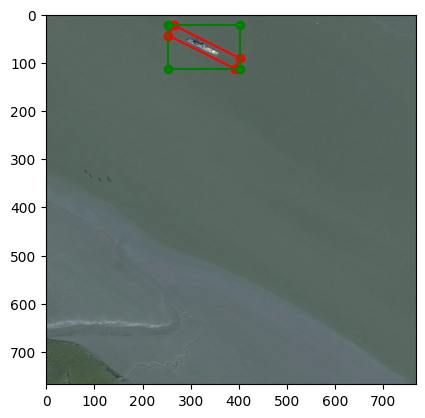

Rotated bounding rectangle: (253.76257244036964,21.33143776387262), (402.2374885947866,111.66857749491643)


In [25]:
%ls /var/env-dataset/

AllImages/    Cloud/  Ice/   test_read_annotation/  train/         val/
Annotations/  Glit/   test/  test_v4.txt*           train_v4.txt*  val_v4.txt*


In [16]:
with open("/var/env-dataset/val_v4.txt") as test_file:
    for line in test_file:
        if  os.path.exists('/var/env-dataset/test_read_annotation/labels_2/'+ line[:-1] + '.txt'):
            # if os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.jpg'):
            #     file = line[:-1] + '.jpg'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.png'):
            #     file = line[:-1] + '.png'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tiff'):
            #     file = line[:-1] + '.tiff'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tif'):
            #     file = line[:-1] + '.tif'
            # else:
            #     print(line[:-1] + ' No existe en images')
            #     continue
            # try:
            #     src = os.path.join('/var/env-dataset/AllImages/', file) # origen
            #     dst = os.path.join('/var/env-dataset/val/images', file) # destino
            #     shutil.move(src, dst)
            # except:
            #     print(f"Error, no se pudo mover el archivo {file}. Verifique los permisos de escritura")
            try:
                file = line[:-1] + '.txt'
                src = os.path.join('/var/env-dataset/test_read_annotation/labels_2/', file) # origen
                dst = os.path.join('/var/env-dataset/val/labels/', file) # destino
                shutil.copy(src, dst)
            except:
                print(f"Error, no se pudo copiar el archivo {file}. Verifique los permisos de escritura")
        else:
            print(line[:-1] + ' No existe en labels')
            

P0696__1__0___924 No existe en labels
P0696__1__515___924 No existe en labels
P0706__1__0___0 No existe en labels
P0706__1__0___158 No existe en labels
P0706__1__87___0 No existe en labels
P0838__1__0___0 No existe en labels
P0838__1__0___641 No existe en labels
P0838__1__282___0 No existe en labels
P0838__1__282___641 No existe en labels
P0897__1__1307___924 No existe en labels
P0897__1__924___1848 No existe en labels
P0897__1__924___924 No existe en labels


In [15]:
with open("/var/env-dataset/test_v4.txt") as test_file:
    for line in test_file:
        if  os.path.exists('/var/env-dataset/test_read_annotation/labels_2/'+ line[:-1] + '.txt'):
            # if os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.jpg'):
            #     file = line[:-1] + '.jpg'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.png'):
            #     file = line[:-1] + '.png'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tiff'):
            #     file = line[:-1] + '.tiff'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tif'):
            #     file = line[:-1] + '.tif'
            # else:
            #     print(line[:-1] + ' No existe en images')
            #     continue
            # try:
            #     src = os.path.join('/var/env-dataset/AllImages/', file) # origen
            #     dst = os.path.join('/var/env-dataset/test/images', file) # destino
            #     shutil.move(src, dst)
            # except:
            #     print(f"Error, no se pudo mover el archivo {file}. Verifique los permisos de escritura")
            try:
                file = line[:-1] + '.txt'
                src = os.path.join('/var/env-dataset/test_read_annotation/labels_2/', file) # origen
                dst = os.path.join('/var/env-dataset/test/labels/', file) # destino
                shutil.copy(src, dst)
            except:
                print(f"Error, no se pudo copiar el archivo {file}. Verifique los permisos de escritura")
        else:
            print(line[:-1] + ' No existe en labels')

P0696__1__0___924 No existe en labels
P0696__1__515___924 No existe en labels
P0706__1__0___0 No existe en labels
P0706__1__0___158 No existe en labels
P0706__1__87___0 No existe en labels
P0838__1__0___0 No existe en labels
P0838__1__0___641 No existe en labels
P0838__1__282___0 No existe en labels
P0838__1__282___641 No existe en labels
P0897__1__1307___924 No existe en labels
P0897__1__924___1848 No existe en labels
P0897__1__924___924 No existe en labels


In [11]:
with open("/var/env-dataset/train_v4.txt") as test_file:
    for line in test_file:
        if  os.path.exists('/var/env-dataset/test_read_annotation/labels_2/'+ line[:-1] + '.txt'):
            # if os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.jpg'):
            #     file = line[:-1] + '.jpg'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.png'):
            #     file = line[:-1] + '.png'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tiff'):
            #     file = line[:-1] + '.tiff'
            # elif os.path.exists('/var/env-dataset/AllImages/'+ line[:-1] + '.tif'):
            #     file = line[:-1] + '.tif'
            # else:
            #     print(line[:-1] + ' No existe en images')
            #     continue
            # try:
            #     src = os.path.join('/var/env-dataset/AllImages/', file) # origen
            #     dst = os.path.join('/var/env-dataset/train/images', file) # destino
            #     shutil.move(src, dst)
            # except:
            #     print(f"Error, no se pudo mover el archivo {file}. Verifique los permisos de escritura")
            try:
                file = line[:-1] + '.txt'
                src = os.path.join('/var/env-dataset/test_read_annotation/labels_2/', file) # origen
                dst = os.path.join('/var/env-dataset/train/labels/', file) # destino
                shutil.copy(src, dst)
            except:
                print(f"Error, no se pudo copiar el archivo {file}. Verifique los permisos de escritura")
        else:
            print(line[:-1] + ' No existe en labels')

P0696__1__0___924 No existe en labels
P0696__1__515___924 No existe en labels
P0706__1__0___0 No existe en labels
P0706__1__0___158 No existe en labels
P0706__1__87___0 No existe en labels
P0838__1__0___0 No existe en labels
P0838__1__0___641 No existe en labels
P0838__1__282___0 No existe en labels
P0838__1__282___641 No existe en labels
P0897__1__1307___924 No existe en labels
P0897__1__924___1848 No existe en labels
P0897__1__924___924 No existe en labels


In [17]:
%ls /var/env-dataset/train/images | wc -l
%ls /var/env-dataset/val/images | wc -l
%ls /var/env-dataset/test/images | wc -l

5466
2047
1193
